In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [18]:
%%cython -a
cimport cython
#cimport numpy as np
import  numpy as np
from libc.math cimport sqrt


@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
cdef int _rotation(double [:,::1] input_data, double [:,::1] output_data,
                  bint interpolation = 0):
    cdef Py_ssize_t r_len, s_len
    r_len = input_data.shape[1]
    s_len = input_data.shape[0]
    cdef Py_ssize_t r_len_half = r_len // 2
        
    cdef Py_ssize_t yy, xx ,rr
    cdef double radius 
    cdef double summed_line_up, summed_line_down
    cdef double interpolated_value_up, interpolated_value_down
    cdef double value_diff_up, value_diff_down
    
    cdef double* value_1_down
    cdef double* value_1_up
    cdef double* value_2_down
    cdef double* value_2_up
    # no interpolation
    # working on interpolation 
    
    cdef Py_ssize_t offset, loop_start
    if  r_len%2 == 0:
        offset = 1
        loop_start = 0
    else:
        offset = 0
        loop_start = 1
        
        yy = 0
        summed_line_up = 0
        # just the middle line 
        if not interpolation:
            for zz in range(s_len):
                for xx in range(r_len_half - yy, 0 , -1):
                    radius = sqrt((yy + 0.25)**2 + (xx - 0.5)**2)
                    rr = int(radius)
                    summed_line_up += (input_data[zz,r_len_half  + rr] 
                                        * (yy + 0.25)/radius)
                output_data[r_len_half - yy ,zz] = 2 * summed_line_up
        else:
            for zz in range(s_len):
                for xx in range(r_len_half - yy, 0 , -1):
                    radius = sqrt((yy + 0.25)**2 + (xx - 0.5)**2)
                    rr = int(radius)
                    value_1_up = &input_data[zz,r_len_half + rr]
                    if r_len_half - 1 == rr:
                        interpolated_value_up = value_1_up[0]
                    else: 
                        value_2_up = &input_data[zz,r_len_half + rr + 1]
                        value_diff_up = value_2_up[0] - value_1_up[0]
                        interpolated_value_up = (value_1_up[0] + 
                                                     value_diff_up
                                                     * (radius - rr))
                    summed_line_up += (interpolated_value_up
                                       * (yy + 0.25)/radius)
                output_data[r_len_half - yy ,zz] = 2 * summed_line_up
            
    if interpolation:
        for zz in range(s_len):
            for yy in range(loop_start, r_len_half):
                summed_line_up = 0
                summed_line_down = 0
                for xx in range(r_len_half - yy, 0 , -1):
                    radius = sqrt((yy + 0.5)**2 + (xx - 0.5)**2)
                    rr = int(radius)
                    value_1_up = &input_data[zz,r_len_half + rr]
                    value_1_down = &input_data[zz, r_len_half - offset - rr]
                    if r_len_half - 1 == rr:
                        interpolated_value_up = value_1_up[0]
                        interpolated_value_down = value_1_down[0]
                    else: 
                        value_2_up = &input_data[zz,r_len_half + rr +1]
                        value_2_down = &input_data[zz,r_len_half  - offset - rr - 1]

                        value_diff_up = value_2_up[0] - value_1_up[0]
                        value_diff_down = value_2_down[0] - value_1_down[0]

                        interpolated_value_up = (value_1_up[0] + 
                                                 value_diff_up
                                                 * (radius - rr))
                        interpolated_value_down = (value_1_down[0] +
                                                   value_diff_down
                                                   * (radius - rr))

                    summed_line_up += (interpolated_value_up 
                                       * (yy + 0.5)/radius)
                    summed_line_down += (interpolated_value_down 
                                         * (yy + 0.5)/radius)
                # multiply with 2 to include the other side (It's identical)
                output_data[r_len_half - offset -yy ,zz] = 2 * summed_line_up
                output_data[r_len_half +  yy, zz]  = 2 * summed_line_down
    else:
        for zz in range(s_len):
            for yy in range(loop_start, r_len_half):
                summed_line_up = 0
                summed_line_down = 0
                for xx in range(r_len_half - yy, 0 , -1):
                    radius = sqrt((yy + 0.5)**2 + (xx - 0.5)**2)
                    rr = int(radius)

                    value_1_up = &input_data[zz,r_len_half + rr]
                    value_1_down = &input_data[zz, r_len_half - offset - rr]

                    interpolated_value_up = value_1_up[0]
                    interpolated_value_down = value_1_down[0]

                    summed_line_up += (interpolated_value_up 
                                       * (yy + 0.5)/radius)
                    summed_line_down += (interpolated_value_down 
                                         * (yy + 0.5)/radius)
                # multiply with 2 to include the other side (It's identical)
                output_data[r_len_half - offset -yy ,zz] = 2 * summed_line_up
                output_data[r_len_half +  yy, zz]  = 2 * summed_line_down

    return loop_start

def rotation(input_data, interpolation = False):
    try:
        input_data.flags
    except AttributeError:
        print('input_data should be a numpy array!')
        raise
    if input_data.flags['F_CONTIGUOUS']:
        print('input_data should be stored in a raw major, C contigous.')
    elif not input_data.flags['C_CONTIGUOUS']:
        print('input_data as to be a contigous array.')
    
    if input_data.dtype != np.float64:
        print('input should be an ndarray of type np.float64.')
        print('Converting to float64 and continuing...')
        input_data = input_data.astype(np.float64)

    output = np.zeros(input_data.size, dtype=np.float64, order='C').reshape(
                    input_data.shape[1], input_data.shape[0])
    
    cdef double [:,::1] input_data_view = input_data
    cdef double [:,::1] output_view = output
    # returned_status just for debugging, flow control. To be removed!
    returned_status = _rotation(input_data_view, output_view, interpolation)
    print(returned_status)
    return output

In [40]:
 path = '../../Faraday_Rotation/data/picels/Vulcan_500fs_a4_Al_5um/product/'
# path = '../../Faraday_Rotation/test_samples/'

In [41]:
file_name = '48'

In [42]:
test_sample = np.load(path + file_name + '.npy')

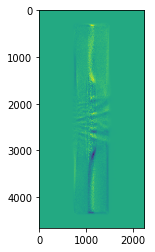

In [43]:
plt.imshow(test_sample)

In [44]:
test_sample.shape

(4660, 2251)

In [74]:
product_rotated = np.ascontiguousarray(test_sample.T[:,:2:-1])

In [75]:
product_rotated.shape

(2251, 4657)

In [76]:
rotated = rotation(product_rotated, interpolation = True)

1


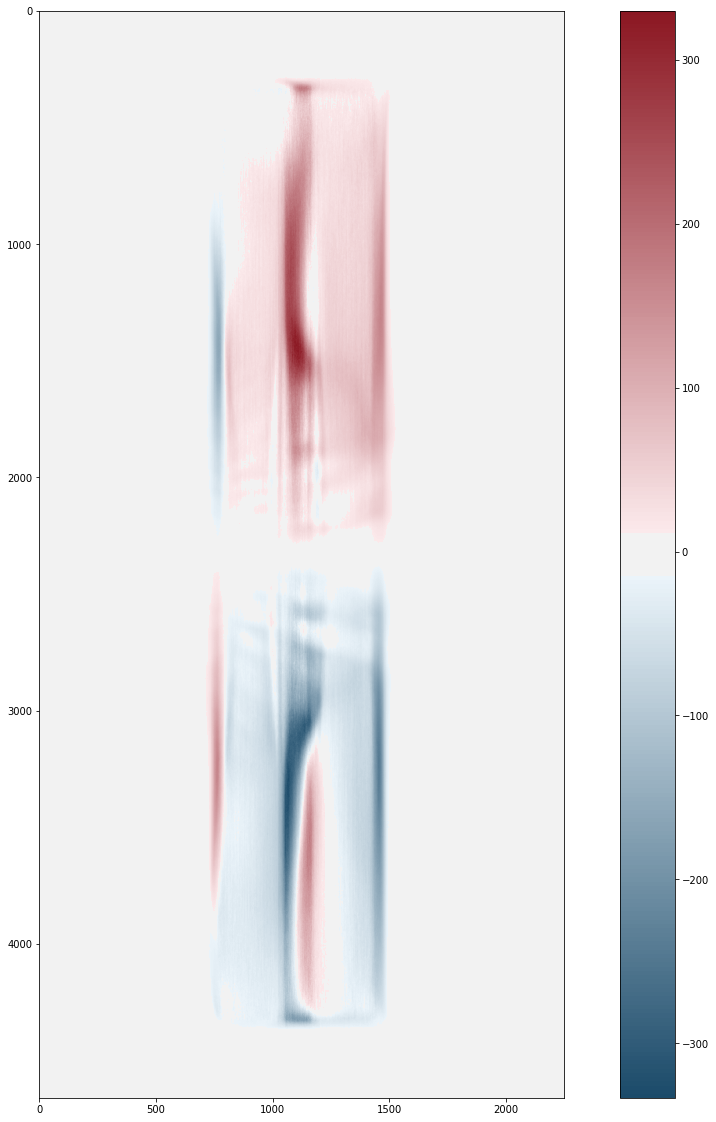

In [60]:
cmap = sns.diverging_palette(240, 10, s=85, l=30, n=256 ,
                                          center = 'light',
                                          as_cmap=True)
f, ax = plt.subplots(1, figsize=(20,20))
ax.imshow(rotated, cmap=cmap)
f.colorbar(ax.images[0])
#f.savefig('w_int.jpg')